## Step 1: Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11
WINDOW_SEC = 3.0
HOP_SEC = 1.5
SR = 16000

BATCH_SIZE = 128
EPOCHS = 50

## Step 3: Load Label Map

In [3]:
import json

with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader (Multi-Label Ready)

In [4]:
def load_split(split):
    X, y = [], []

    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1  # multi-label compatible

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Train / Val / Test

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: CNN Architecture (For baseline model to avoid regularization)

In [6]:
def build_instrunet_baseline():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)


## Step 7: Compile Model (BCE + SGD)

In [7]:
model = build_instrunet_baseline()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,667 (1.49 MB)

 Trainable params: 390,667 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

## Step 9: Class Weights Preparation

In [10]:
# Inverse frequency weighting
class_counts = y_train.sum(axis=0)
total_samples = y_train.shape[0]
num_classes = y_train.shape[1]

class_weights = {
    i: total_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
}

## Step 10: Train Model

In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.7948 - loss: 0.6116

37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.8676 - loss: 0.5050 - val_binary_accuracy: 0.9091 - val_loss: 0.3262 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3114

37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3080 - val_binary_accuracy: 0.9091 - val_loss: 0.3052 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3054

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3052 - val_binary_accuracy: 0.9091 - val_loss: 0.3049 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3064

37/37 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - binary_accuracy: 0.9091 - loss: 0.3051 - val_binary_accuracy: 0.9091 - val_loss: 0.3047 - learning_rate: 0.0100
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3051 - val_binary_accuracy: 0.9091 - val_loss: 0.3051 - learning_rate: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3050 - val_binary_accuracy: 0.9091 - val_loss: 0.3049 - learning_rate: 0.0100
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3049 - val_binary_accuracy: 0.9091 - val_loss: 0.3047 - learning_rate: 0.0100
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3055

37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - binary_accuracy: 0.9091 - loss: 0.3049 - val_binary_accuracy: 0.9091 - val_loss: 0.3041 - learning_rate: 0.0100
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - binary_accuracy: 0.9091 - loss: 0.3047 - val_binary_accuracy: 0.9091 - val_loss: 0.3046 - learning_rate: 0.0100
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3060

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3048 - val_binary_accuracy: 0.9091 - val_loss: 0.3040 - learning_rate: 0.0100
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3048 - val_binary_accuracy: 0.9091 - val_loss: 0.3041 - learning_rate: 0.0100
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3045 - val_binary_accuracy: 0.9091 - val_loss: 0.3043 - learning_rate: 0.0100
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - binary_accuracy: 0.9091 - loss: 0.3046 - val_binary_accuracy: 0.9091 - val_loss: 0.3047 - learning_rate: 0.0100
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - binary_accuracy: 0.9091 - loss: 0.3045 - val_binary_accuracy: 0.9091 - val_loss: 0.3048 - learning_rate: 0.0100
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3043

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3043 - val_binary_accuracy: 0.9091 - val_loss: 0.3040 - learning_rate: 0.0100
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - binary_accuracy: 0.9091 - loss: 0.3042 - val_binary_accuracy: 0.9091 - val_loss: 0.3042 - learning_rate: 0.0050
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3034

37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - binary_accuracy: 0.9091 - loss: 0.3041 - val_binary_accuracy: 0.9091 - val_loss: 0.3040 - learning_rate: 0.0050
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3032

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3040 - val_binary_accuracy: 0.9091 - val_loss: 0.3039 - learning_rate: 0.0050
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3041 - val_binary_accuracy: 0.9091 - val_loss: 0.3039 - learning_rate: 0.0050
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3041

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3040 - val_binary_accuracy: 0.9091 - val_loss: 0.3038 - learning_rate: 0.0050
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - binary_accuracy: 0.9091 - loss: 0.3040 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1011s 28s/step - binary_accuracy: 0.9091 - loss: 0.3039 - val_binary_accuracy: 0.9091 - val_loss: 0.3037 - learning_rate: 0.0050
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9091 - loss: 0.3053

37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - binary_accuracy: 0.9091 - loss: 0.3039 - val_binary_accuracy: 0.9091 - val_loss: 0.3036 - learning_rate: 0.0050
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - binary_accuracy: 0.9091 - loss: 0.3039 - val_binary_accuracy: 0.9091 - val_loss: 0.3039 - learning_rate: 0.0050
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - binary_accuracy: 0.9091 - loss: 0.3038 - val_binary_accuracy: 0.9091 - val_loss: 0.3038 - learning_rate: 0.0050
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3034

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3038 - val_binary_accuracy: 0.9091 - val_loss: 0.3036 - learning_rate: 0.0050
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - binary_accuracy: 0.9091 - loss: 0.3037 - val_binary_accuracy: 0.9091 - val_loss: 0.3036 - learning_rate: 0.0050
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3047

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3037 - val_binary_accuracy: 0.9091 - val_loss: 0.3035 - learning_rate: 0.0050
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - binary_accuracy: 0.9091 - loss: 0.3036 - val_binary_accuracy: 0.9091 - val_loss: 0.3035 - learning_rate: 0.0050
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3035 - val_binary_accuracy: 0.9091 - val_loss: 0.3035 - learning_rate: 0.0050
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3042

37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - binary_accuracy: 0.9091 - loss: 0.3035 - val_binary_accuracy: 0.9091 - val_loss: 0.3032 - learning_rate: 0.0050
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - binary_accuracy: 0.9091 - loss: 0.3035 - val_binary_accuracy: 0.9091 - val_loss: 0.3032 - learning_rate: 0.0050
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3034 - val_binary_accuracy: 0.9091 - val_loss: 0.3033 - learning_rate: 0.0050
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3033 - val_binary_accuracy: 0.9091 - val_loss: 0.3034 - learning_rate: 0.0050
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3040

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3033 - val_binary_accuracy: 0.9091 - val_loss: 0.3031 - learning_rate: 0.0050
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3032 - val_binary_accuracy: 0.9091 - val_loss: 0.3031 - learning_rate: 0.0050
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3032 - val_binary_accuracy: 0.9091 - val_loss: 0.3032 - learning_rate: 0.0050
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3032

37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - binary_accuracy: 0.9091 - loss: 0.3031 - val_binary_accuracy: 0.9091 - val_loss: 0.3029 - learning_rate: 0.0050
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3036

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3030 - val_binary_accuracy: 0.9091 - val_loss: 0.3028 - learning_rate: 0.0050
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3035

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3030 - val_binary_accuracy: 0.9091 - val_loss: 0.3027 - learning_rate: 0.0050
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3033

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3029 - val_binary_accuracy: 0.9091 - val_loss: 0.3027 - learning_rate: 0.0050
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3027

37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - binary_accuracy: 0.9091 - loss: 0.3029 - val_binary_accuracy: 0.9091 - val_loss: 0.3026 - learning_rate: 0.0050
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9091 - loss: 0.3027 - val_binary_accuracy: 0.9091 - val_loss: 0.3027 - learning_rate: 0.0050
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3023

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3027 - val_binary_accuracy: 0.9091 - val_loss: 0.3026 - learning_rate: 0.0050
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3030

37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - binary_accuracy: 0.9091 - loss: 0.3026 - val_binary_accuracy: 0.9091 - val_loss: 0.3023 - learning_rate: 0.0050
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - binary_accuracy: 0.9091 - loss: 0.3025 - val_binary_accuracy: 0.9091 - val_loss: 0.3023 - learning_rate: 0.0050
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3024 - val_binary_accuracy: 0.9091 - val_loss: 0.3026 - learning_rate: 0.0050
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3037

37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9091 - loss: 0.3024 - val_binary_accuracy: 0.9091 - val_loss: 0.3021 - learning_rate: 0.0050
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3026

37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - binary_accuracy: 0.9091 - loss: 0.3022 - val_binary_accuracy: 0.9091 - val_loss: 0.3020 - learning_rate: 0.0050
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9091 - loss: 0.3022

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - binary_accuracy: 0.9091 - loss: 0.3021 - val_binary_accuracy: 0.9091 - val_loss: 0.3020 - learning_rate: 0.0050
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - binary_accuracy: 0.9091 - loss: 0.3021 - val_binary_accuracy: 0.9091 - val_loss: 0.3021 - learning_rate: 0.0050


## Step 11: Accuracy Curve

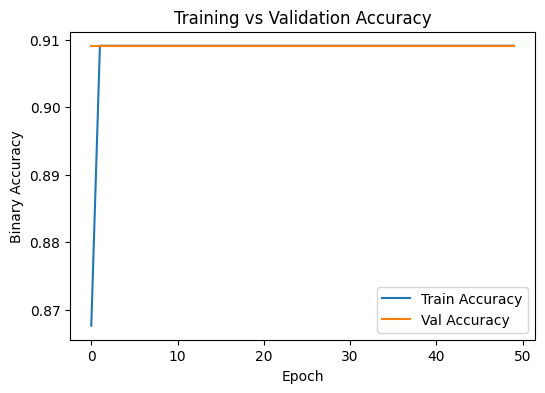

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 12: Training Loss and Validation Loss Curves

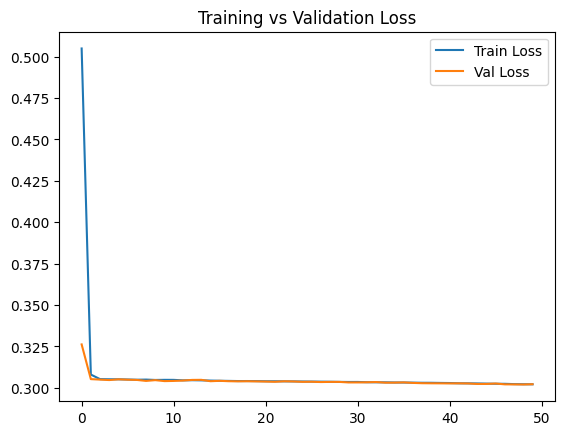

In [15]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 13: CNN Architecture (Model with regularization applied)

In [16]:
def build_instrunet_regularized():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 14: Model compile (BCE + SGD)

In [17]:
model = build_instrunet_regularized()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,587 (1.50 MB)

 Trainable params: 391,627 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 15: Callbacks

In [18]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_regularized.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.5816 - loss: 0.6772

37/37 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - binary_accuracy: 0.6636 - loss: 0.6466 - val_binary_accuracy: 0.9091 - val_loss: 0.5835 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8383 - loss: 0.5542

37/37 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - binary_accuracy: 0.8624 - loss: 0.5261 - val_binary_accuracy: 0.9091 - val_loss: 0.4745 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8996 - loss: 0.4501

37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - binary_accuracy: 0.9038 - loss: 0.4284 - val_binary_accuracy: 0.9091 - val_loss: 0.3962 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9097 - loss: 0.3701

37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - binary_accuracy: 0.9103 - loss: 0.3560 - val_binary_accuracy: 0.9091 - val_loss: 0.3501 - learning_rate: 0.0100
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9113 - loss: 0.3192

37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.9108 - loss: 0.3115 - val_binary_accuracy: 0.9091 - val_loss: 0.3283 - learning_rate: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9107 - loss: 0.2920

37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - binary_accuracy: 0.9107 - loss: 0.2853 - val_binary_accuracy: 0.9091 - val_loss: 0.3242 - learning_rate: 0.0100
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9108 - loss: 0.2724

37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9113 - loss: 0.2702 - val_binary_accuracy: 0.9091 - val_loss: 0.3229 - learning_rate: 0.0100
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9117 - loss: 0.2597

37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9121 - loss: 0.2594 - val_binary_accuracy: 0.9091 - val_loss: 0.3214 - learning_rate: 0.0100
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9126 - loss: 0.2540

37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - binary_accuracy: 0.9129 - loss: 0.2524 - val_binary_accuracy: 0.9094 - val_loss: 0.3206 - learning_rate: 0.0100
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9135 - loss: 0.2469

37/37 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - binary_accuracy: 0.9134 - loss: 0.2466 - val_binary_accuracy: 0.9115 - val_loss: 0.3173 - learning_rate: 0.0100
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9144 - loss: 0.2435

37/37 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - binary_accuracy: 0.9145 - loss: 0.2406 - val_binary_accuracy: 0.9113 - val_loss: 0.3154 - learning_rate: 0.0100
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9163 - loss: 0.2372

37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - binary_accuracy: 0.9165 - loss: 0.2365 - val_binary_accuracy: 0.9063 - val_loss: 0.3106 - learning_rate: 0.0100
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9170 - loss: 0.2324

37/37 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - binary_accuracy: 0.9165 - loss: 0.2326 - val_binary_accuracy: 0.9042 - val_loss: 0.3036 - learning_rate: 0.0100
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9181 - loss: 0.2282

37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9173 - loss: 0.2295 - val_binary_accuracy: 0.9056 - val_loss: 0.2867 - learning_rate: 0.0100
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9180 - loss: 0.2263

37/37 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - binary_accuracy: 0.9189 - loss: 0.2248 - val_binary_accuracy: 0.9006 - val_loss: 0.2850 - learning_rate: 0.0100
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - binary_accuracy: 0.9197 - loss: 0.2219 - val_binary_accuracy: 0.8948 - val_loss: 0.2906 - learning_rate: 0.0100
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9211 - loss: 0.2165

37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - binary_accuracy: 0.9209 - loss: 0.2190 - val_binary_accuracy: 0.9038 - val_loss: 0.2680 - learning_rate: 0.0100
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9205 - loss: 0.2166

37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9216 - loss: 0.2158 - val_binary_accuracy: 0.9145 - val_loss: 0.2449 - learning_rate: 0.0100
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9227 - loss: 0.2143

37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9235 - loss: 0.2135 - val_binary_accuracy: 0.9177 - val_loss: 0.2293 - learning_rate: 0.0100
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9235 - loss: 0.2119

37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9238 - loss: 0.2107 - val_binary_accuracy: 0.9176 - val_loss: 0.2242 - learning_rate: 0.0100
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9251 - loss: 0.2054

37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9253 - loss: 0.2083 - val_binary_accuracy: 0.9197 - val_loss: 0.2218 - learning_rate: 0.0100
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9238 - loss: 0.2092

37/37 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - binary_accuracy: 0.9250 - loss: 0.2058 - val_binary_accuracy: 0.9207 - val_loss: 0.2172 - learning_rate: 0.0100
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9268 - loss: 0.2033 - val_binary_accuracy: 0.9201 - val_loss: 0.2198 - learning_rate: 0.0100
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9273 - loss: 0.2006 - val_binary_accuracy: 0.9151 - val_loss: 0.2345 - learning_rate: 0.0100
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9276 - loss: 0.1994 - val_binary_accuracy: 0.9162 - val_loss: 0.2272 - learning_rate: 0.0100
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9287 - loss: 0.1971 - val_binary_accuracy: 0.9166 - val_loss: 0.2247 - learning_rate: 0.0100
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9298 - loss: 0.1954 - val_binary_accuracy: 0.9157 - val_loss: 0.2310 - learning_rate: 0.0100
Epoch 28/50
37/3

37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9308 - loss: 0.1923 - val_binary_accuracy: 0.9224 - val_loss: 0.2124 - learning_rate: 0.0050
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9317 - loss: 0.1887

37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9306 - loss: 0.1911 - val_binary_accuracy: 0.9268 - val_loss: 0.2006 - learning_rate: 0.0050
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9317 - loss: 0.1888

37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9320 - loss: 0.1886 - val_binary_accuracy: 0.9274 - val_loss: 0.1995 - learning_rate: 0.0050
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.9320 - loss: 0.1883 - val_binary_accuracy: 0.9267 - val_loss: 0.2032 - learning_rate: 0.0050
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9322 - loss: 0.1880

37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9329 - loss: 0.1865 - val_binary_accuracy: 0.9287 - val_loss: 0.1993 - learning_rate: 0.0050
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9333 - loss: 0.1867 - val_binary_accuracy: 0.9271 - val_loss: 0.2008 - learning_rate: 0.0050
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9332 - loss: 0.1827

37/37 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - binary_accuracy: 0.9331 - loss: 0.1854 - val_binary_accuracy: 0.9284 - val_loss: 0.1981 - learning_rate: 0.0050
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9344 - loss: 0.1839

37/37 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - binary_accuracy: 0.9334 - loss: 0.1843 - val_binary_accuracy: 0.9317 - val_loss: 0.1960 - learning_rate: 0.0050
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9333 - loss: 0.1852

37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9339 - loss: 0.1830 - val_binary_accuracy: 0.9308 - val_loss: 0.1922 - learning_rate: 0.0050
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9347 - loss: 0.1823 - val_binary_accuracy: 0.9273 - val_loss: 0.1989 - learning_rate: 0.0050
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9356 - loss: 0.1790

37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9339 - loss: 0.1816 - val_binary_accuracy: 0.9317 - val_loss: 0.1898 - learning_rate: 0.0050
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9353 - loss: 0.1804 - val_binary_accuracy: 0.9324 - val_loss: 0.1900 - learning_rate: 0.0050
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - binary_accuracy: 0.9352 - loss: 0.1799 - val_binary_accuracy: 0.9301 - val_loss: 0.1925 - learning_rate: 0.0050
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.9358 - loss: 0.1783 - val_binary_accuracy: 0.9301 - val_loss: 0.1913 - learning_rate: 0.0050
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - binary_accuracy: 0.9352 - loss: 0.1777 - val_binary_accuracy: 0.9276 - val_loss: 0.2000 - learning_rate: 0.0050
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9349 - loss: 0.1774

37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9359 - loss: 0.1769 - val_binary_accuracy: 0.9325 - val_loss: 0.1871 - learning_rate: 0.0050
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.9361 - loss: 0.1763 - val_binary_accuracy: 0.9298 - val_loss: 0.1927 - learning_rate: 0.0050
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - binary_accuracy: 0.9368 - loss: 0.1752 - val_binary_accuracy: 0.9328 - val_loss: 0.1896 - learning_rate: 0.0050
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.9367 - loss: 0.1750 - val_binary_accuracy: 0.9292 - val_loss: 0.1948 - learning_rate: 0.0050
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9369 - loss: 0.1749

37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9377 - loss: 0.1732 - val_binary_accuracy: 0.9339 - val_loss: 0.1853 - learning_rate: 0.0050
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9378 - loss: 0.1730 - val_binary_accuracy: 0.9339 - val_loss: 0.1885 - learning_rate: 0.0050
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - binary_accuracy: 0.9379 - loss: 0.1718 - val_binary_accuracy: 0.9309 - val_loss: 0.1917 - learning_rate: 0.0050
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9381 - loss: 0.1706 - val_binary_accuracy: 0.9324 - val_loss: 0.1873 - learning_rate: 0.0050


## Step 16: Accuracy Curve

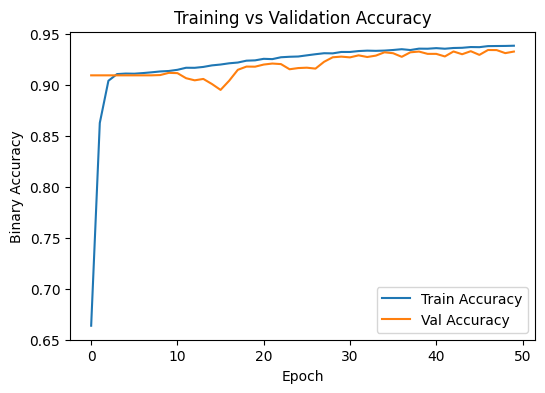

In [21]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 17:Training Loss and Validation Loss Curves

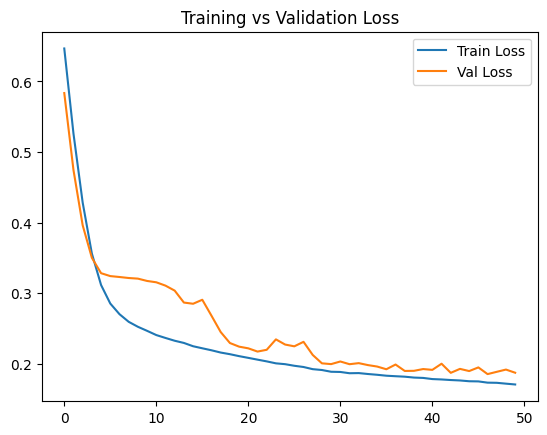

In [22]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 19: Model Evaluation with Thresholded Metrics

### (a) Generate probabilities

In [23]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step


### (b) Apply thresholding

In [24]:
THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

print(f"Using decision threshold = {THRESHOLD}")

Using decision threshold = 0.3


### (c) Global F1 scores

In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

In [34]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("=== Global Metrics ===")
print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))

=== Global Metrics ===
Micro F1-score : 0.5792
Macro F1-score : 0.5398


### (d) Per-class Recall (CRITICAL)

In [35]:
recalls = recall_score(y_test, y_pred, average=None)

print("\n=== Per-class Recall ===")
for i, r in enumerate(recalls):
    print(f"{id_to_class[i]} : {round(r, 3)}")


=== Per-class Recall ===
cel : 0.362
cla : 0.461
flu : 0.397
gac : 0.789
gel : 0.412
org : 0.709
pia : 0.796
sax : 0.234
tru : 0.477
vio : 0.161
voi : 0.761


### (e) Per-class Precision

In [36]:
precisions = precision_score(
    y_test,
    y_pred,
    average=None,
    zero_division=0
)

print("\n=== Per-class Precision ===")
for i, p in enumerate(precisions):
    print(f"{id_to_class[i]} : {round(p, 3)}")


=== Per-class Precision ===
cel : 0.778
cla : 0.547
flu : 0.422
gac : 0.568
gel : 0.635
org : 0.689
pia : 0.717
sax : 0.55
tru : 0.631
vio : 0.5
voi : 0.856


### (f) Per-class Confusion Matrices

In [37]:
print("\n=== Per-class Confusion Matrices ===")
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


=== Per-class Confusion Matrices ===

Confusion Matrix for cel
[[942   6]
 [ 37  21]]

Confusion Matrix for cla
[[901  29]
 [ 41  35]]

Confusion Matrix for flu
[[901  37]
 [ 41  27]]

Confusion Matrix for gac
[[854  57]
 [ 20  75]]

Confusion Matrix for gel
[[865  27]
 [ 67  47]]

Confusion Matrix for org
[[870  33]
 [ 30  73]]

Confusion Matrix for pia
[[864  34]
 [ 22  86]]

Confusion Matrix for sax
[[894  18]
 [ 72  22]]

Confusion Matrix for tru
[[896  24]
 [ 45  41]]

Confusion Matrix for vio
[[905  14]
 [ 73  14]]

Confusion Matrix for voi
[[874  15]
 [ 28  89]]


### (g) Plotting of ROC-AUC curve (AUC score per class)

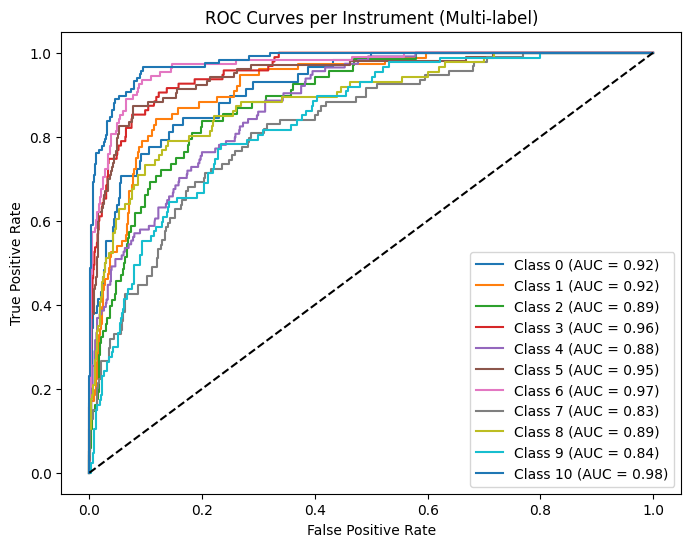

In [38]:
plt.figure(figsize=(8, 6))

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument (Multi-label)")
plt.legend()
plt.show()

### (h) Micro-Averaged and Macro-Averaged F1 Score

In [39]:
micro_auc = roc_auc_score(y_test, y_prob, average="micro")
print("Micro-average ROC–AUC:", micro_auc)

Micro-average ROC–AUC: 0.9154221292523191


In [40]:
macro_auc = roc_auc_score(y_test, y_prob, average="macro")
print("Macro-average ROC–AUC:", macro_auc)

Macro-average ROC–AUC: 0.9102410408174506
